## Traffic Sign Classification with TensorFlow

In this notebook, we'll build a convolutional neural network (CNN) using TensorFlow and Keras to classify traffic signs. The dataset consists of labeled images of various traffic signs.

### I - Import Necessary Libraries

Import the required libraries and modules for the project.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import glob
import os

from tensorflow.keras.layers import Dense , Flatten , Dropout , Conv2D , MaxPooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping

### II - Load and Display Labels

Load the labels CSV file into a Pandas DataFrame and display it.

In [2]:
path = './input/labels.csv'
df = pd.read_csv(path)

In [3]:
df

ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       Go Left
23       23              Go Left or right
24       24                      Go Right
25       25                     keep Left
26       26                    keep Right
27       27          Roundabout mandatory
28       28            watch out for cars
29       29                          Horn
30       30             Bicycles crossing
31       31                         Uturn
32       32                  Road Divider
33       33               Traffic signals
34       34                  Danger Ahead
35       35                Zebra Crossing
36       36             Bicycles crossing
37       37             Children crossing
38       38   Dangerous curve to the left
39       39  Dangerous curve to the right
40       40                      Unknown1
41       41                      Unknown2
42       42                      Unknown3
43       43          Go right or straight
44       44           Go left or straight
45       45                      Unknown4
46       46                  ZigZag Curve
47       47                Train Crossing
48       48            Under Construction
49       49                      Unknown5
50       50                        Fences
51       51       Heavy Vehicle Accidents
52       52                      Unknown6
53       53                      Give Way
54       54                   No stopping
55       55                      No entry
56       56                      Unknown7
57       57                      Unknown8

### III - Explore and Visualize the Dataset

Explore the dataset by creating a DataFrame with information about the number of images for each class and visualizing it using seaborn.


In [4]:
dataset = './input/traffic_Data/DATA'

In [23]:
data = []
entry = []
for filename in os.listdir(dataset):
  num_images = 0
  entry.append(df['Name'][int(filename)])
  for image in os.listdir(dataset + '/' + filename):
    num_images = num_images + 1
  entry.append(num_images)
  print(entry)
  data.append(entry[:2])
  entry.clear()
# Create a DataFrame for visualization
display_data = pd.DataFrame(data,columns=['Name' , 'num_images'])

['Speed limit (5km/h)', 118]
['Speed limit (15km/h)', 40]
['Dont Go straight', 70]
['Dont Go Left', 138]
['Dont Go Left or Right', 96]
['Dont Go Right', 36]
['Dont overtake from Left', 128]
['No Uturn', 22]
['No Car', 142]
['No horn', 130]
['Speed limit (40km/h)', 8]
['Speed limit (50km/h)', 4]
['Speed limit (30km/h)', 80]
['Go straight or right', 18]
['Go straight', 12]
['Go Left', 18]
['Go Left or right', 14]
['Go Right', 100]
['keep Left', 2]
['keep Right', 126]
['Roundabout mandatory', 28]
['watch out for cars', 446]
['Horn', 44]
['Speed limit (40km/h)', 260]
['Bicycles crossing', 150]
['Uturn', 42]
['Road Divider', 14]
['Traffic signals', 4]
['Danger Ahead', 26]
['Zebra Crossing', 156]
['Bicycles crossing', 40]
['Children crossing', 58]
['Dangerous curve to the left', 30]
['Dangerous curve to the right', 34]
['Speed limit (50km/h)', 98]
['Unknown1', 32]
['Unknown2', 18]
['Unknown3', 32]
['Go right or straight', 82]
['Go left or straight', 30]
['Unknown4', 24]
['ZigZag Curve', 18]


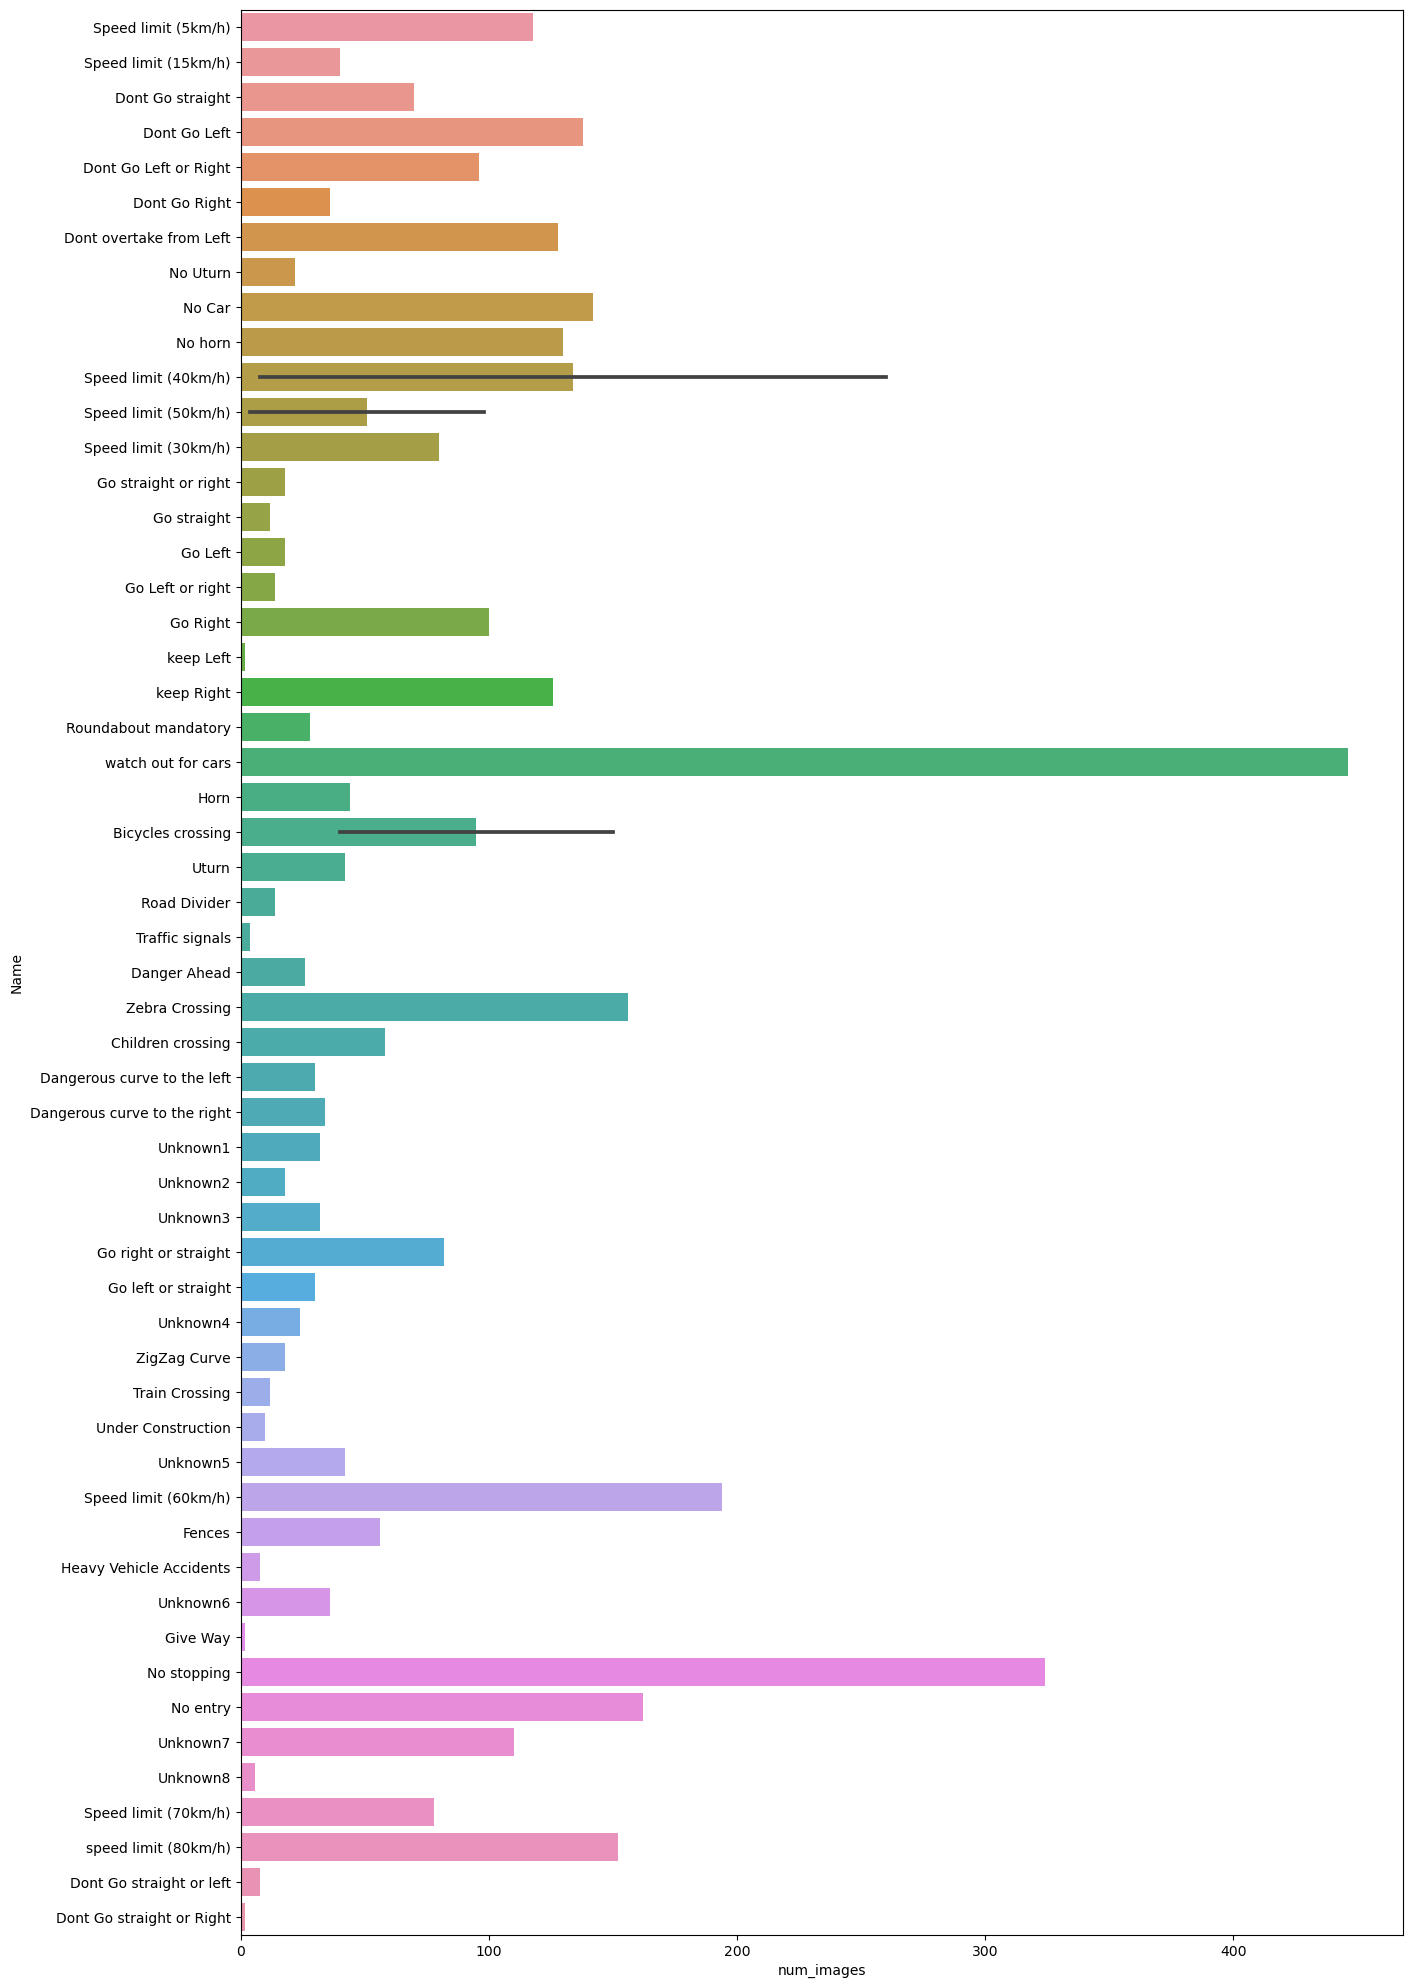

In [24]:
# Visualize the dataset using seaborn
plt.figure(figsize=(15,25))
ax = sns.barplot(x='num_images',y='Name' , data=display_data)

### IV - Preprocess and Load Image Data

Preprocess and load the image data into training and validation datasets using TensorFlow's image_dataset_from_directory.


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='training',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='validation',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [9]:
# Map class numbers to class names for visualization
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

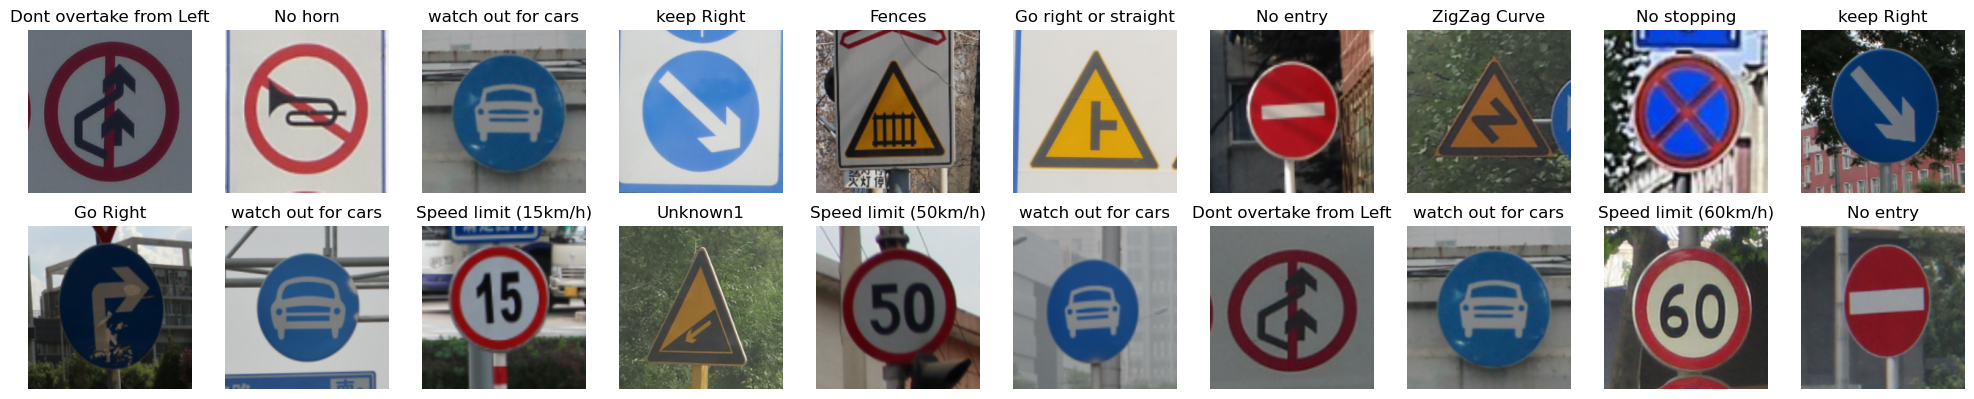

In [10]:
# Visualize a few images from the training dataset
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

### V - Data Augmentation and Model Building

Apply data augmentation to enhance the diversity of the training dataset and build a Convolutional Neural Network (CNN) model.


In [11]:
# Data Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
   tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
  ]
)

In [12]:
# Build the model
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128 ,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(len(df) , activation = 'softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                

### VI - Compile and Train the Model

Compile the model and set up early stopping as a callback. Then, train the model on the training dataset.


In [13]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam' , metrics=['accuracy'])

In [14]:
# Set callback functions to early stop training 
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# Train the model
hist = model.fit(train_ds,validation_data=val_ds, epochs=20 , callbacks=mycallbacks )

Epoch 1/20


105/105 [==============================] - 269s 2s/step - loss: 3.1926 - accuracy: 0.1808 - val_loss: 2.4184 - val_accuracy: 0.3645
Epoch 2/20
105/105 [==============================] - 245s 2s/step - loss: 2.2611 - accuracy: 0.3285 - val_loss: 1.8938 - val_accuracy: 0.4388
Epoch 3/20
105/105 [==============================] - 241s 2s/step - loss: 1.9190 - accuracy: 0.3966 - val_loss: 1.6122 - val_accuracy: 0.4748
Epoch 4/20
105/105 [==============================] - 232s 2s/step - loss: 1.7425 - accuracy: 0.4394 - val_loss: 1.5707 - val_accuracy: 0.5240
Epoch 5/20
105/105 [==============================] - 238s 2s/step - loss: 1.5593 - accuracy: 0.4982 - val_loss: 1.3322 - val_accuracy: 0.5659
Epoch 6/20
105/105 [==============================] - 235s 2s/step - loss: 1.4868 - accuracy: 0.5081 - val_loss: 1.3984 - val_accuracy: 0.5755
Epoch 7/20
105/105 [==============================] - 238s 2s/step - loss: 1.3933 - accuracy: 0.5453 - val_loss: 1.2427 - val_accuracy: 0.61

### VII - Visualize Training History

Visualize the training history, including loss and accuracy, using matplotlib.

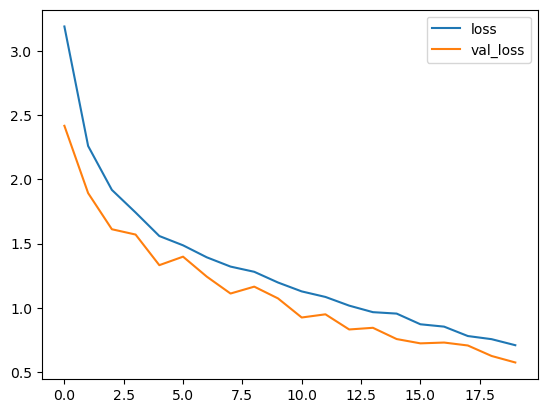

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')

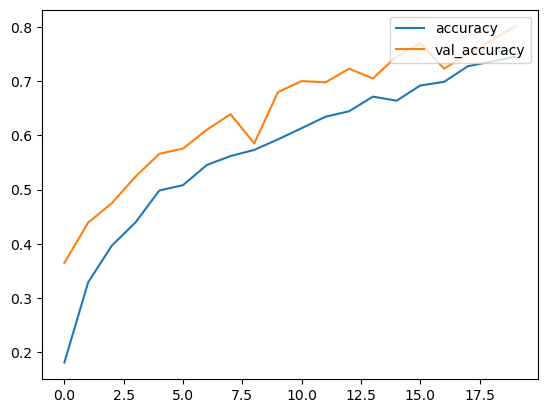

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')

In [19]:
# Save the model to a file
model.save('traffic_signs.keras')

### VIII - Test an External Image 

Define a function to test an external image with the trained model.

In [17]:
def test_external_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Predict class probabilities
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Map predicted class number to class name
    predicted_class_name = df['Name'][predicted_class]

    # Display the image and predicted class
    plt.imshow(img_array[0].astype("uint8"))
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis("off")
    plt.show()